In [3]:
import gensim
import numpy as np
import pandas as pd
import os
import re
import csv
import codecs
import sys
import pickle

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from utils import score

from keras import callbacks
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
import pydot
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from string import punctuation

from keras import backend as K
from keras.engine.topology import Layer
#from keras import initializations
from keras import initializers, regularizers, constraints
seed = 1
np.random.seed(seed)
from IPython.display import SVG
from keras.utils import model_to_dot


Using TensorFlow backend.


# LOAD DATASET

In [11]:
# Read the text files of fnc data
train_bodies = pd.read_csv('/Users/iris/Desktop/FNC/fnc-1/train_bodies.csv')
test_bodies = pd.read_csv('/Users/iris/Desktop/FNC/fnc-1/test_bodies.csv')
train_df = pd.read_csv('/Users/iris/Desktop/FNC/fnc-1/train_stances.csv')
test_df = pd.read_csv('/Users/iris/Desktop/FNC/fnc-1/test_unlabel.csv')

In [12]:
train_df.replace('unrelated',0,True)
train_df.replace('agree',1,True)
train_df.replace('disagree',2,True)
train_df.replace('discuss',3,True)

In [13]:
combine_df_train = train_df.join(train_bodies.set_index('Body ID'), on='Body ID')
combine_df_test = test_df.join(test_bodies.set_index('Body ID'), on='Body ID')

In [14]:
combine_df_train.head()

,Headline,Body ID,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,712,0,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,158,1,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",137,0,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,0,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1923,2,"Fear not arachnophobes, the story of Bunbury's..."


#reference:https://github.com/Youlina3/FNC-1-Challenge/blob/master/LSTMs%2C%20Bidirectional%20LSTMs%20and%20LSTMs%20with%20Attention.ipynb

In [15]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq_head_train = [text_to_word_sequence(head) for head in combine_df_train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(body) for body in combine_df_train['articleBody']]
word_seq_head_test = [text_to_word_sequence(head) for head in combine_df_test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(body) for body in combine_df_test['articleBody']]

In [16]:
word_seq = []
for i in range(len(word_seq_head_train)):
    word_seq.append(word_seq_head_train[i])
for i in range(len(word_seq_bodies_train)):
    word_seq.append(word_seq_bodies_train[i])
for i in range(len(word_seq_head_test)):
    word_seq.append(word_seq_head_test[i])
for i in range(len(word_seq_bodies_test)):
    word_seq.append(word_seq_bodies_test[i])

In [17]:
filter_list = '!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer(num_words=40000, filters=filter_list)
tokenizer.fit_on_texts([seq for seq in word_seq])
#because it only includes unique words(tokens)

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 35978


In [18]:
# Combine headline and body together
word_seq_train = [list(i) for i in word_seq_head_train]
for i in range(len(word_seq_head_train)):
    word_seq_train[i].extend(word_seq_bodies_train[i]) 
    
word_seq_test = [list(i) for i in word_seq_head_test]
for i in range(len(word_seq_head_test)):
    word_seq_test[i].extend(word_seq_bodies_test[i])

In [19]:
X_train = tokenizer.texts_to_sequences([' '.join(seq[:150]) for seq in word_seq_train])
X_train = pad_sequences(X_train, maxlen=150, padding='post', truncating='post')
y_train = combine_df_train['Stance']

In [20]:
X_test = tokenizer.texts_to_sequences([' '.join(seq[:150]) for seq in word_seq_test])
X_test = pad_sequences(X_test, maxlen=150, padding='post', truncating='post')

In [21]:
encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [22]:
X_train, X_vali, y_train, y_vali = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)

# Build Model

In [ ]:
#Loda word2vec model
w2v_input_file =  '/Users/iris/Desktop/GoogleNews-vectors-negative300.bin.gz'
embeddings = gensim.models.KeyedVectors.load_word2vec_format(w2v_input_file, binary=True)

In [ ]:
#create embedding matrix
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 100)) 
for word, i in tokenizer.word_index.items(): 
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector

del embeddings

# LSTM MODEL

In [ ]:
#Build a sequential model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=50, input_length=150,
                    weights = [embeddings_matrix], trainable=True, name='word_embedding_layer'))
lstm_model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer1'))
lstm_model.add(Dropout(rate=0.2, name='dropout_1')) 
lstm_model.add(Dense(4, activation='softmax', name='output_layer'))
lstm_model.summary()

In [ ]:
#compile model
lstm_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
#set up callbacks
filepath="./result/lstm/epoch40/lstm_150token_lr0.001_trainable_{epoch:02d}_.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc',
                                       mode='max',
                                       verbose=0, 
                                       save_best_only=True)

es = [checkpoint]

In [ ]:
#Train model with 40 epochs and 128 batch size
history_lstm=lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, validation_data=(X_vali, y_vali),callbacks=es)

score, acc = lstm_model.evaluate(X_vali,y_vali,
                                batch_size=128)
print("Accuracy on the test set = {0:4.3f}".format(acc))
lstm_model.save('/Users/iris/Desktop/as6/lstm.model')

In [ ]:
SVG(model_to_dot(lstm_model,show_layer_names=True,show_shapes=True,dpi=70).create(prog='dot', format='svg'))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#Accuracy score visualization
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM MODEL PREDICTION

In [ ]:
#define evaluation function
def evaluate_answer(model,model_inp, true):
    inv_category_dict = {0:'unrelated', 1: 'agree', 2: 'disagree', 3: 'discuss'}
    predicted = model.predict(model_inp)
    predicted = np.argmax(predicted,axis = 1)
    t = np.argmax(true,axis = 1)
    ground = list()
    pred = list()
    for i in predicted:
        pred.append(inv_category_dict[i])
    for i in t:
        ground.append(inv_category_dict[i])
    score.report_score(ground, pred)

In [ ]:
#Loading LSTM model
model_file_path = '/Users/iris/Desktop/as6/lstm.model'
model= models.load_model(model_file_path)

In [ ]:
evaluate_answer(model,X_vali,y_vali)

In [ ]:
#Using lstm model predict test data
preds = model.predict(X_test)
outputs = [np.argmax(p, axis = -1) for p in preds]

In [ ]:
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "agree"
    if outputs[i] == 2: outputs[i] = "disagree"
    if outputs[i] == 3: outputs[i] = "discuss"

In [ ]:
#save predicted results
df_predicted = {}
df_predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([test_df, df_predicted], axis=1, sort=False)
result.to_csv('/Users/iris/Desktop/as6/lstm.csv', index=False, encoding='utf-8')

# BILSTM MODEL with ReLu activation

In [ ]:
#Load GloVe embedding model
glove_input_file = "Users/iris/Desktop/glove.100d.txt"
word2vec_output_file = 'glove.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [ ]:
#create embedding matrix
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, 100)) 
for word, i in tokenizer.word_index.items(): 
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    

    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector

del embeddings

In [37]:
#Build sequential model with relu activation and 0.2 dropout rate
model_1 = Sequential()
model_1.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=100,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer', #False
                          mask_zero=True))
model_1.add(Bidirectional(LSTM(100, return_sequences=False, name='Bidrectional_lstm_layer1')))
model_1.add(Dropout(0.2,name='dropout_1'))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(rate=0.2, name='dropout_2')) 
model_1.add(Dense(4, activation='softmax', name='output_layer'))
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 100)         3597900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 132       
Total params: 3,765,264
Trainable params: 3,765,264
Non-trainable params: 0
____________________________________________

In [38]:
filepath="./result/lstm/epoch40/Bidirectional_lstm_150token_lr0.001_trainable_{epoch:02d}_.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_acc',
                                       mode='max',
                                       verbose=0, 
                                       save_best_only=True)

callbacks_list1 = [checkpoint]

In [39]:
#compile model
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [40]:
#Train model with 40 epochs and 128 batch_size
history= model_1.fit(X_train, y_train,
          batch_size=128,
          epochs=40,
          validation_data=(X_vali, y_vali),callbacks = callbacks_list1)

/Users/iris/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 44974 samples, validate on 4998 samples
Epoch 1/40
44974/44974 [==============================] - 152s 3ms/step - loss: 0.6880 - accuracy: 0.7537 - val_loss: 0.5038 - val_accuracy: 0.8125
Epoch 2/40


/Users/iris/opt/miniconda3/envs/Assignment2/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


44974/44974 [==============================] - 151s 3ms/step - loss: 0.4279 - accuracy: 0.8388 - val_loss: 0.3951 - val_accuracy: 0.8527
Epoch 3/40
44974/44974 [==============================] - 151s 3ms/step - loss: 0.3035 - accuracy: 0.8826 - val_loss: 0.2863 - val_accuracy: 0.8906
Epoch 4/40
44974/44974 [==============================] - 158s 4ms/step - loss: 0.2260 - accuracy: 0.9125 - val_loss: 0.2377 - val_accuracy: 0.9082
Epoch 5/40
44974/44974 [==============================] - 158s 4ms/step - loss: 0.1719 - accuracy: 0.9341 - val_loss: 0.2074 - val_accuracy: 0.9252
Epoch 6/40
44974/44974 [==============================] - 151s 3ms/step - loss: 0.1294 - accuracy: 0.9495 - val_loss: 0.1951 - val_accuracy: 0.9284
Epoch 7/40
44974/44974 [==============================] - 151s 3ms/step - loss: 0.1030 - accuracy: 0.9619 - val_loss: 0.1746 - val_accuracy: 0.9382
Epoch 8/40
44974/44974 [==============================] - 152s 3ms/step - loss: 0.0785 - accuracy: 0.9706 - val_loss: 0.175

In [41]:
model_1.save('/Users/iris/Desktop/as6/reluBilstm.model')

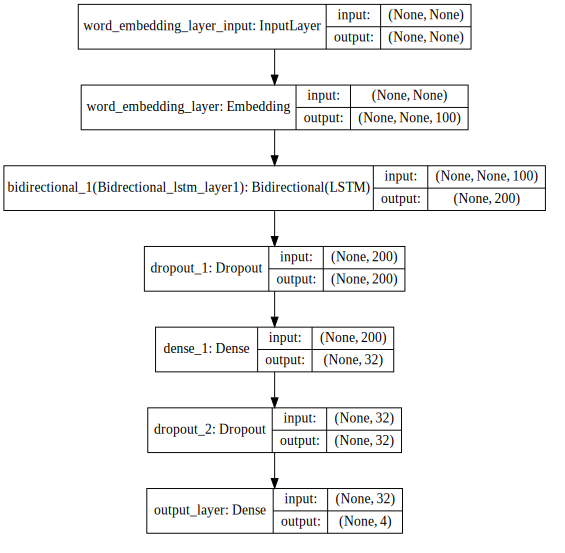

In [42]:
SVG(model_to_dot(model_1,show_layer_names=True,show_shapes=True,dpi=70).create(prog='dot', format='svg'))

In [49]:
import matplotlib.pyplot as plt

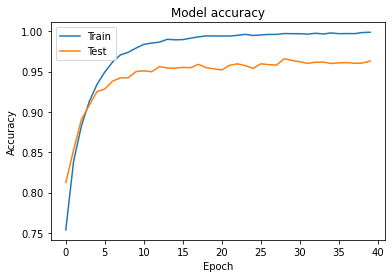

In [50]:
#Accuracy score visualization
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Bilstm model Prediction

In [24]:
from keras import models

In [25]:
#loading model
model_file_path = '/Users/iris/Desktop/as6/reluBilstm.model'
model_1 = models.load_model(model_file_path)

/Users/iris/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [26]:
evaluate_answer(model_1,X_vali,y_vali)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    326    |    18     |    17     |    27     |
-------------------------------------------------------------
| disagree  |    15     |    56     |     1     |     5     |
-------------------------------------------------------------
|  discuss  |     9     |     4     |    847    |    29     |
-------------------------------------------------------------
| unrelated |    24     |     7     |    29     |   3584    |
-------------------------------------------------------------
Score: 2141.0 out of 2265.0	(94.52538631346579%)


In [1]:
#Predict test data
preds = model_1.predict(X_test)
outputs = [np.argmax(p, axis = -1) for p in preds]

NameError: name 'model_1' is not defined

In [ ]:
for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "agree"
    if outputs[i] == 2: outputs[i] = "disagree"
    if outputs[i] == 3: outputs[i] = "discuss"

In [ ]:
#saving test data
df_predicted = {}
df_predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([test_df, df_predicted], axis=1, sort=False)
result.to_csv('/Users/iris/Desktop/as6/reluBilstm.csv', index=False, encoding='utf-8')